# Track filtering/fitting with LSTMs

This is a continuous space model using the ACTS data.

This should eventually move into a more appropriate folder. It's just here now for convenience.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
cuda = True

In [37]:
from __future__ import print_function

# System imports
import ast
import multiprocessing as mp
from timeit import default_timer as timer

# Data libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt

# Local imports
from data import load_data_events

# Magic
%matplotlib notebook

## Utilities

In [3]:
def process_hits_data(df, copy_keys=['evtid', 'barcode', 'volid', 'layid']):
    """Split columns and calculate some derived variables"""
    x = df.gpos.apply(lambda pos: pos[0])
    y = df.gpos.apply(lambda pos: pos[1])
    z = df.gpos.apply(lambda pos: pos[2])
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return df[copy_keys].assign(z=z.astype(np.float32), r=r.astype(np.float32),
                                phi=phi.astype(np.float32))

def read_worker(hits_file):
    hits_columns = ['hitid', 'barcode', 'volid', 'layid', 'lpos',
                    'lerr', 'gpos', 'chans', 'dir', 'direrr']
    return process_hits_data(load_data_events(hits_file, columns=hits_columns))

def process_files(hits_files, num_workers):
    """Load and process a set of hits files with MP"""
    pool = mp.Pool(processes=num_workers)
    hits = pool.map(read_worker, hits_files)
    pool.close()
    pool.join()
    # Fix the evtid to be consecutive
    for i in range(1, len(hits)):
        hits[i].evtid += hits[i-1].evtid.iloc[-1] + 1
    return pd.concat(hits, ignore_index=True)

In [4]:
def select_hits(hits):
    # Select all barrel hits
    vids = [8, 13, 17]
    barrel_hits = hits[np.logical_or.reduce([hits.volid == v for v in vids])]
    # Re-enumerate the volume and layer numbers for convenience
    volume = pd.Series(-1, index=barrel_hits.index, dtype=np.int8)
    vid_groups = barrel_hits.groupby('volid')
    for i, v in enumerate(vids):
        volume[vid_groups.get_group(v).index] = i
    # This assumes 4 layers per volume (except last volume)
    layer = (barrel_hits.layid / 2 - 1 + volume * 4).astype(np.int8)
    return (barrel_hits[['evtid', 'barcode', 'phi', 'z']]
            .assign(volume=volume, layer=layer))

def select_signal_hits(hits):
    """Select signal hits from tracks that hit all barrel layers"""
    return (hits.groupby(['evtid', 'barcode'])
            # Select tracks that hit every layer at least once
            .filter(lambda x: len(x) >= 10 and x.layer.unique().size == 10)
            # Average duplicate hits together
            .groupby(['evtid', 'barcode', 'layer'], as_index=False).mean())

## Read the data

In [5]:
data_dir = '/bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29'

In [6]:
n_files = 12

all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(data_dir, f) for f in hits_files[:n_files]]

In [7]:
n_workers = 4
hits = process_files(hits_files, num_workers=n_workers)

Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_11.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_100.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_10.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_1.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_12.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_13.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_14.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_15.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_16.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_17.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_18.csv
Loading /bigdata/shared/ACTS/prod_mu10_pt1000_2017_07_29/clusters_19.csv


In [8]:
print('Hits data shape:', hits.shape)

Hits data shape: (6304246, 7)


In [9]:
%%time

# Select hits
selected_hits = select_hits(hits)
print('selected barrel hits:', selected_hits.shape)
signal_hits = select_signal_hits(selected_hits)
print('signal track hits:', signal_hits.shape)

selected barrel hits: (3969422, 6)
signal track hits: (1632090, 6)
CPU times: user 1min 55s, sys: 7.44 s, total: 2min 2s
Wall time: 2min 1s


In [10]:
%%time

# Gather features into tensor of shape (events, layers, features)
input_data = np.stack(signal_hits.groupby(['evtid', 'barcode'])
                      .apply(lambda x: x[['phi', 'z', 'layer']].values)).astype(np.float32)

# Scale coordinates to approx [-1, 1] for phi and z, [0, 1] for layer number
coord_scale = np.array([np.pi, 1000., 10.])
input_data[:,:] /= coord_scale

CPU times: user 1min 53s, sys: 1.58 s, total: 1min 55s
Wall time: 1min 53s


In [90]:
# Scale coordinates to approximately [-1, 1] for phi, z and [0, 1] for layer
coord_scale = np.array([np.pi, 1000., 10.])

In [11]:
input_data.shape

(163209, 10, 3)

## Define the model

We define an LSTM model in PyTorch which will predict the next hit location.

In [24]:
# CUDA memory allocations
if cuda:
    np_to_torch = lambda x: Variable(torch.from_numpy(x)).cuda()
    create_tensor_var = lambda *size: Variable(torch.cuda.FloatTensor(*size).zero_())
else:
    np_to_torch = lambda x: Variable(torch.from_numpy(x))
    create_tensor_var = lambda *size: Variable(torch.FloatTensor(*size).zero_())

In [25]:
class TrackFilterer(nn.Module):

    def __init__(self, input_dim=3, hidden_dim=5, output_dim=2, n_lstm_layers=1):
        super(TrackFilterer, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        input_size = x.size()
        # Initialize the lstm hidden state
        h = (create_tensor_var(self.lstm.num_layers, input_size[0], self.lstm.hidden_size),
             create_tensor_var(self.lstm.num_layers, input_size[0], self.lstm.hidden_size))
        x, h = self.lstm(x, h)
        # Flatten layer axis into batch axis so FC applies independently across layers.
        x = (self.fc(x.contiguous().view(-1, x.size(-1)))
             .view(input_size[0], input_size[1], -1))
        return x

## Configure and train the model

In [14]:
def training_step(model, inputs, targets, loss_func, optimizer):
    model.zero_grad()
    outputs = model(inputs)
    loss = loss_func(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss

In [83]:
# Model config
hidden_dim = 10
n_lstm_layers = 1

# Train config
n_epochs = 10
batch_size = 32
test_frac = 0.1

In [84]:
# Split data into training, validation, and test sets
train_data, test_data = sklearn.model_selection.train_test_split(input_data, test_size=test_frac)

# Inputs are the hits from [0, N-1)
# Targets are the hits from [1, N) without the layer feature.
train_input = np_to_torch(train_data[:,:-1])
train_target = np_to_torch(train_data[:,1:,:2])
test_input = np_to_torch(test_data[:,:-1])
test_target = np_to_torch(test_data[:,1:,:2])

n_samples = train_input.size(0)
n_batches = (n_samples + batch_size - 1) // batch_size
print('Training samples:', n_samples)
print('Batches per epoch:', n_batches)
print('Test samples:', test_input.size(0))

Training samples: 146888
Batches per epoch: 4591
Test samples: 16321


In [85]:
# Construct the model
model = TrackFilterer(hidden_dim=hidden_dim)
if cuda:
    model.cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_func = nn.MSELoss()

print(model)
print('Parameters:', sum(param.numel() for param in model.parameters()))

TrackFilterer (
  (lstm): LSTM(3, 10, batch_first=True)
  (fc): Linear (10 -> 2)
)
Parameters: 622


In [86]:
batch_idxs = np.arange(0, n_samples, batch_size)
train_losses, valid_losses = [], []

for i in range(n_epochs):
    print('Epoch', i)
    start_time = timer()
    sum_loss = 0

    for j in batch_idxs:
        batch_input = train_input[j:j+batch_size]
        batch_target = train_target[j:j+batch_size]
        sum_loss += training_step(model, batch_input, batch_target, loss_func, optimizer)

    end_time = timer()
    avg_loss = sum_loss.cpu().data[0] / n_batches
    train_losses.append(avg_loss)
    print('  training loss %.3g' % avg_loss, 'time %gs' % (end_time - start_time))
    
    # Evaluate the model on the validation set
    valid_loss = loss_func(model(test_input), test_target).cpu().data[0]
    valid_losses.append(valid_loss)
    print('  validate loss %.3g' % valid_loss)

Epoch 0
  training loss 0.0173 time 16.1489s
  validate loss 0.00736
Epoch 1
  training loss 0.00714 time 16.2101s
  validate loss 0.00729
Epoch 2
  training loss 0.00709 time 16.4076s
  validate loss 0.00724
Epoch 3
  training loss 0.00703 time 15.9947s
  validate loss 0.00719
Epoch 4
  training loss 0.00698 time 16.2305s
  validate loss 0.00715
Epoch 5
  training loss 0.00694 time 16.1772s
  validate loss 0.0071
Epoch 6
  training loss 0.00687 time 16.2995s
  validate loss 0.00701
Epoch 7
  training loss 0.00681 time 16.232s
  validate loss 0.00696
Epoch 8
  training loss 0.00677 time 16.2297s
  validate loss 0.00692
Epoch 9
  training loss 0.00673 time 16.1774s
  validate loss 0.00687


<IPython.core.display.Javascript object>


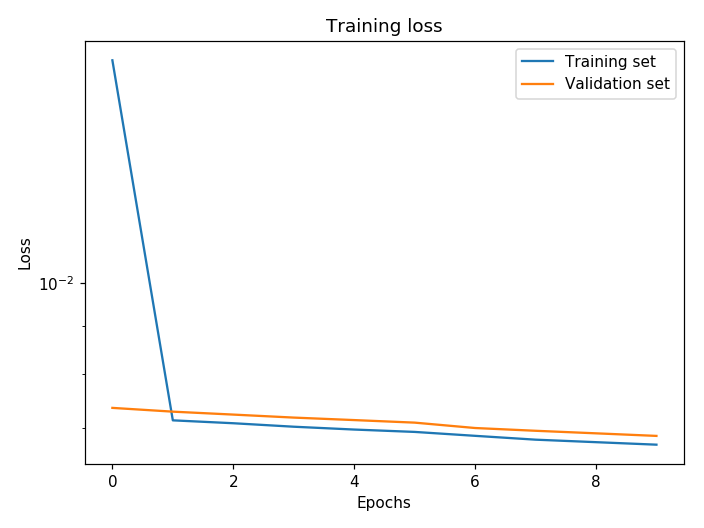

In [87]:
plt.figure()
epochs = np.arange(n_epochs)
plt.semilogy(epochs, np.array(train_losses), label='Training set')
plt.semilogy(epochs, np.array(valid_losses), label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.tight_layout()

## Evaluate model performance

In [91]:
# Get the predictions and errors for the full training set
train_output = model(train_input)
train_error = train_output - train_target
train_resid = train_error.cpu().data.numpy() * coord_scale[:2]

# Get the predictions and errors for the full test set
test_output = model(test_input)
test_error = test_output - test_target
test_resid = test_error.cpu().data.numpy() * coord_scale[:2]

<IPython.core.display.Javascript object>


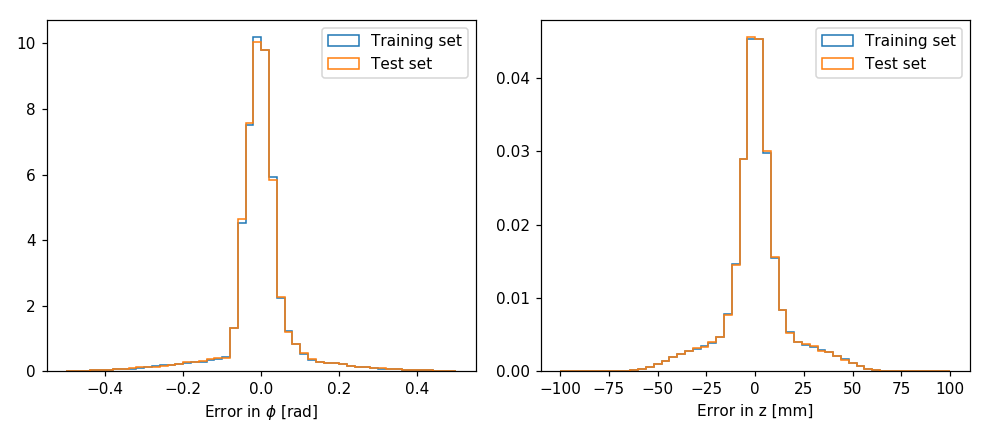

In [117]:
plt.figure(figsize=(9,4))
plt.subplot(121)
hist_args = dict(bins=50, range=(-0.5, 0.5), normed=True, log=False, histtype='step')
plt.hist(train_resid[:,:,0].flatten(), label='Training set', **hist_args)
plt.hist(test_resid[:,:,0].flatten(), label='Test set', **hist_args)
plt.xlabel('Error in $\phi$ [rad]')
plt.legend(loc=0)

plt.subplot(122)
hist_args = dict(bins=50, range=(-100, 100), normed=True, log=False, histtype='step')
plt.hist(train_resid[:,:,1].flatten(), label='Training set', **hist_args)
plt.hist(test_resid[:,:,1].flatten(), label='Test set', **hist_args)
plt.xlabel('Error in z [mm]')
plt.legend(loc=0)
plt.tight_layout()

#### Observations

- The $\phi$ residual has a funny asymmetric shape. Not sure what's going on there.
- Training and test set agree perfectly.
- Non-gaussian tails in the Z residual.

## Visualize trajectories

<IPython.core.display.Javascript object>


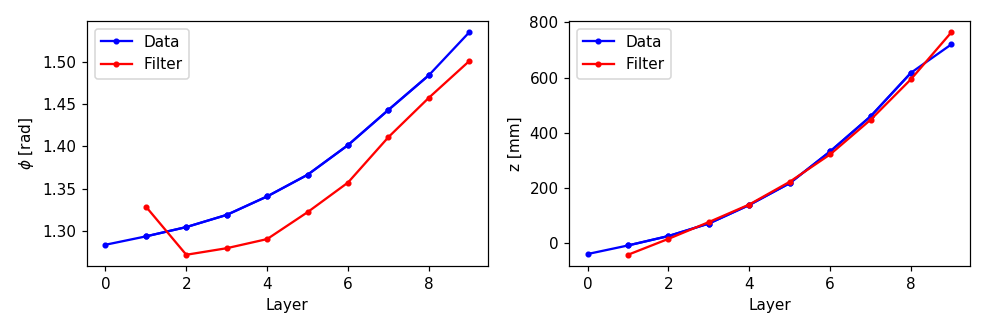

<IPython.core.display.Javascript object>


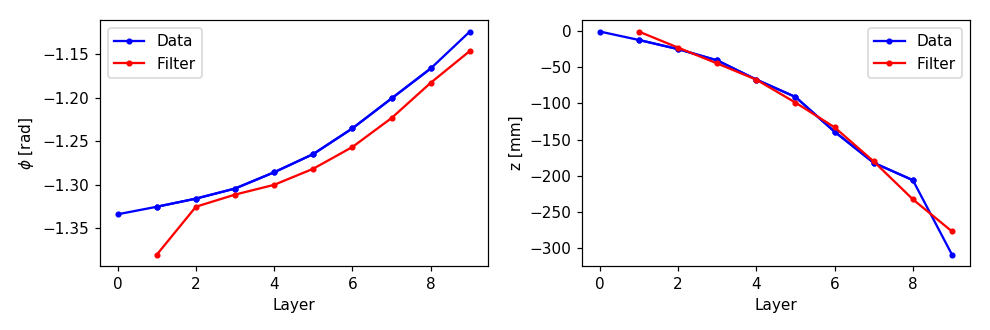

<IPython.core.display.Javascript object>


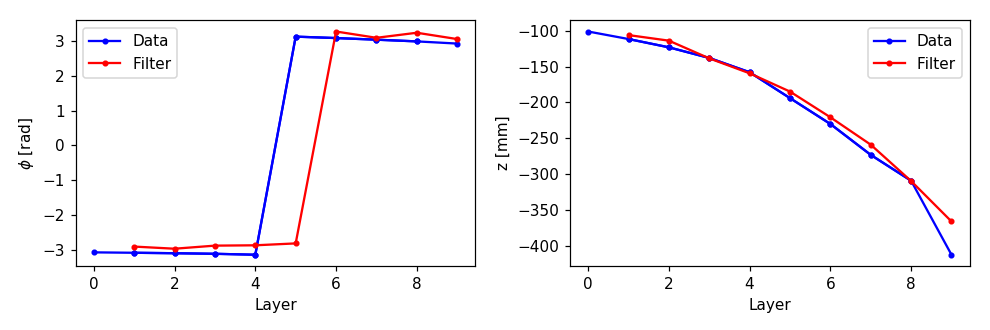

<IPython.core.display.Javascript object>


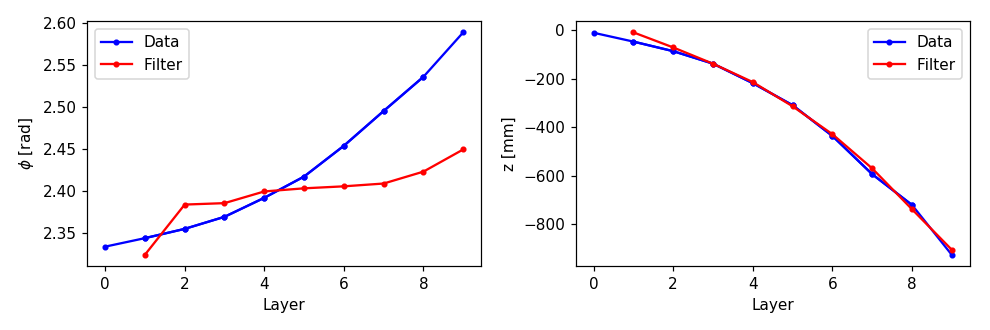

<IPython.core.display.Javascript object>


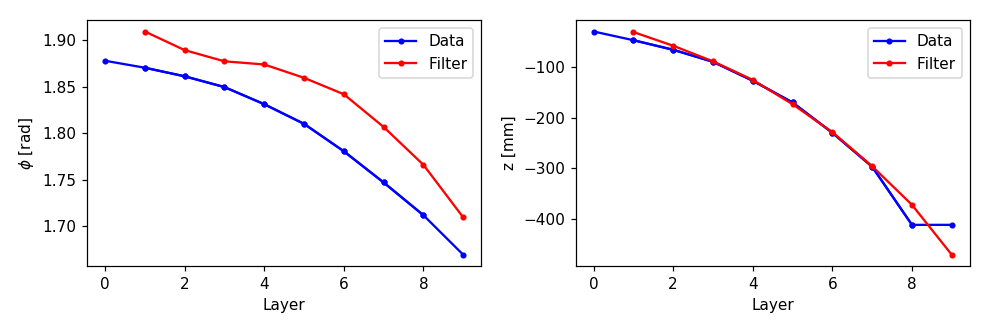

<IPython.core.display.Javascript object>


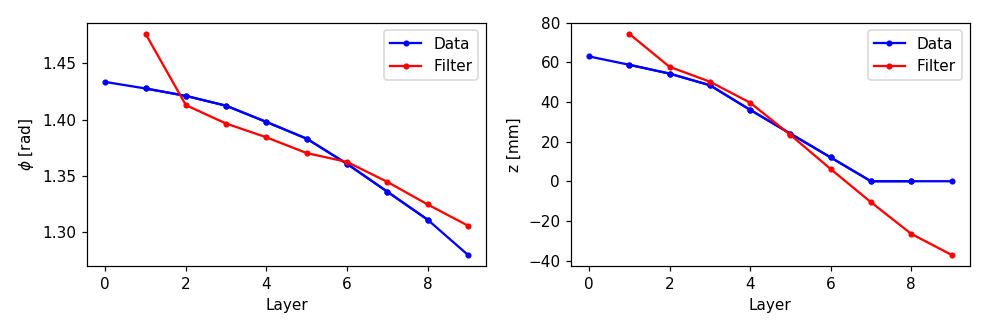

In [126]:
for i in range(6):
    layers = np.arange(10)
    inputs = test_input[i].cpu().data.numpy() * coord_scale
    outputs = test_output[i].cpu().data.numpy() * coord_scale[:2]
    targets = test_target[i].cpu().data.numpy() * coord_scale[:2]

    plt.figure(figsize=(9,3))

    plt.subplot(121)
    plt.plot(layers[:-1], inputs[:,0], 'b.-')
    plt.plot(layers[1:], targets[:,0], 'b.-', label='Data')
    plt.plot(layers[1:], outputs[:,0], 'r.-', label='Filter')
    plt.xlabel('Layer')
    plt.ylabel('$\phi$ [rad]')
    plt.legend(loc=0)

    plt.subplot(122)
    plt.plot(layers[:-1], inputs[:,1], 'b.-')
    plt.plot(layers[1:], targets[:,1], 'b.-', label='Data')
    plt.plot(layers[1:], outputs[:,1], 'r.-', label='Filter')
    plt.xlabel('Layer')
    plt.ylabel('z [mm]')
    plt.legend(loc=0)

    plt.tight_layout()

#### Observations

- Wrap-around at $\phi = \pi$ screws up the third example.
- Filter is often smoother than data in the coarse outer layers.
- The $\phi$ prediction generally tries to converge on the data but often slow.
- The 4th example shows divergence from data.